# Test Training

In this notebook we test the training of the OpenPose PE model

In [1]:
import os
import sys
import json
import collections
from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.nn import DataParallel
import torchvision

sys.path.append("..")

from data import StyledCoco
import models
import CONSTANTS
from CONFIG import CONFIG
import data
import lib.arguments as arguments
import lib.utils as utils
import lib.metrics as metrics
import lib.pose_parsing as pose_parsing 
import lib.visualizations as visualizations

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
test_exp = "test/experiment_2020-06-04_08-06-38"
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], test_exp)

In [4]:
IDX_TO_NAME = {0: 'Nose', 1: 'Neck', 2: 'Right Shoulder', 3: 'Right Elbow', 4: 'Right Wrist', 5: 'Left Shoulder',
               6: 'Left Elbow', 7: 'Left Wrist', 8: 'Right Hip', 9: 'Right Knee', 10: 'Right Ankle',
               11: 'Left Hip', 12: 'Left Knee', 13: 'Left Ankle', 14: 'Right Eye', 15: 'Left Eye', 16: 'Right Ear',
               17: 'Left Ear'}

In [5]:
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["training"]["batch_size"] = 1
exp_data["dataset"]["dataset_name"] = "coco"
exp_data["model"]["model_name"] = "OpenPose"

In [6]:
_, valid_loader = data.load_dataset(exp_data=exp_data, train=False,
                                    validation=True, shuffle_train=True,
                                    shuffle_valid=False)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


## Testing Training/Inference

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.OpenPose()
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "OpenPose", "checkpoint_iter_370000.pth")
model.load_pretrained(pretrained_path)

In [8]:
model = DataParallel(model).to(device)

In [9]:
# model.train()
# n_epochs = 3
# lr = 0.00001
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

# total_steps = 0

# for e in range(n_epochs):
    
#     total_losses = [0, 0] * (1 + 1)
    
#     for i, (img, heatmaps, pafs, mask, _) in enumerate(tqdm(train_loader)):

#         # preprocessing
#         optimizer.zero_grad()
#         img, heatmaps = img.float(), heatmaps.float()
#         pafs, mask = pafs.float(), mask.float()
#         img, heatmaps = img.to(device), heatmaps.to(device)
#         pafs, mask = pafs.to(device), mask.to(device)
        
#         # forward pass
#         stages_output = model(img)
#         stages_output = stages_output
        
#         break 
        
#         # loss computation
#         loss_contributions = []
#         for stage_idx in range(len(total_losses) // 2):
#             heatmap_loss = metrics.masked_l2_loss(prediction=stages_output[stage_idx*2],
#                                                   target=heatmaps, mask=mask, batch_size=img.shape[0])
#             paf_loss = metrics.masked_l2_loss(prediction=stages_output[stage_idx*2+1],
#                                               target=pafs, mask=mask, batch_size=img.shape[0])
#             total_losses[stage_idx * 2] += heatmap_loss
#             total_losses[stage_idx * 2 + 1] += paf_loss
#             loss_contributions.append(heatmap_loss)
#             loss_contributions.append(paf_loss)
#         loss = torch.stack(loss_contributions).sum()
#         if(i%100==0):
#             print(loss)

#     break

# print(f"Loss: {loss}")

In [10]:
iterator = iter(valid_loader)
for i in range(12):
    img, heatmaps, pafs, mask, metadata = next(iterator)

In [11]:
model.eval()
stages_output = model(img.to(device).float())

In [12]:
print(img.shape)

torch.Size([1, 3, 600, 600])


In [13]:
print(len(stages_output))
print(stages_output[0].shape)
print(stages_output[1].shape)
print(stages_output[2].shape)
print(stages_output[3].shape)

4
torch.Size([1, 19, 75, 75])
torch.Size([1, 38, 75, 75])
torch.Size([1, 19, 75, 75])
torch.Size([1, 38, 75, 75])


In [14]:
# print(heatmaps.shape)
# print(pafs.shape)
# print(all_pred_heats.shape)

In [15]:
upsample_ratio = 8
img_idx = 0

cur_img = img[img_idx,:].cpu().numpy()
all_label_heats = heatmaps[img_idx,:].cpu().numpy()[:,:]
all_label_pafs = pafs[img_idx,:].cpu().numpy()[:,:]
label_heats = heatmaps[img_idx,:].cpu().numpy()[-1,:]
label_pafs = pafs[img_idx,:].cpu().numpy()[-1,:]

all_pred_heats = stages_output[-2].cpu().detach().numpy()[img_idx,:,:]
all_pred_pafs = stages_output[-1].cpu().detach().numpy()[img_idx,:,:]
cur_heats = stages_output[-2].cpu().detach().numpy()[img_idx,-1,:]
cur_pafs = stages_output[-1].cpu().detach().numpy()[img_idx,-1,:]

cur_heats = cv2.resize(cur_heats, (0, 0), fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC)
cur_pafs = cv2.resize(cur_pafs, (0, 0), fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC)

all_pred_heats = cv2.resize(all_pred_heats.transpose(1,2,0), (0, 0), fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC).transpose(2,0,1)
all_pred_pafs = cv2.resize(all_pred_pafs.transpose(1,2,0), (0, 0), fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC).transpose(2,0,1)

# all_pred_heats = pose_parsing.reorder_heatmaps(all_pred_heats)
# all_pred_pafs = pose_parsing.reorder_pafs(all_pred_pafs)

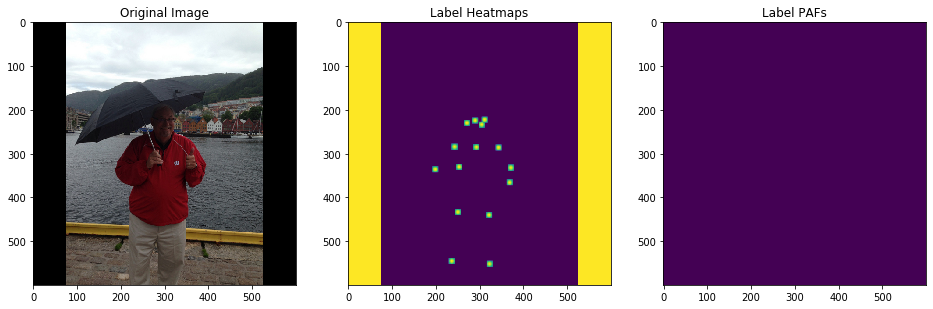

In [16]:
plt.figure(figsize=(16, 5))

plt.subplot(1,3,1)
ax = plt.gca()
visualizations.visualize_image(cur_img, ax=ax, title="Original Image")

plt.subplot(1,3,2)
ax = plt.gca()
visualizations.visualize_heatmap(label_heats, ax=ax, title="Label Heatmaps")

plt.subplot(1,3,3)
ax = plt.gca()
visualizations.visualize_paf(label_pafs, ax=ax, title="Label PAFs")

plt.show()

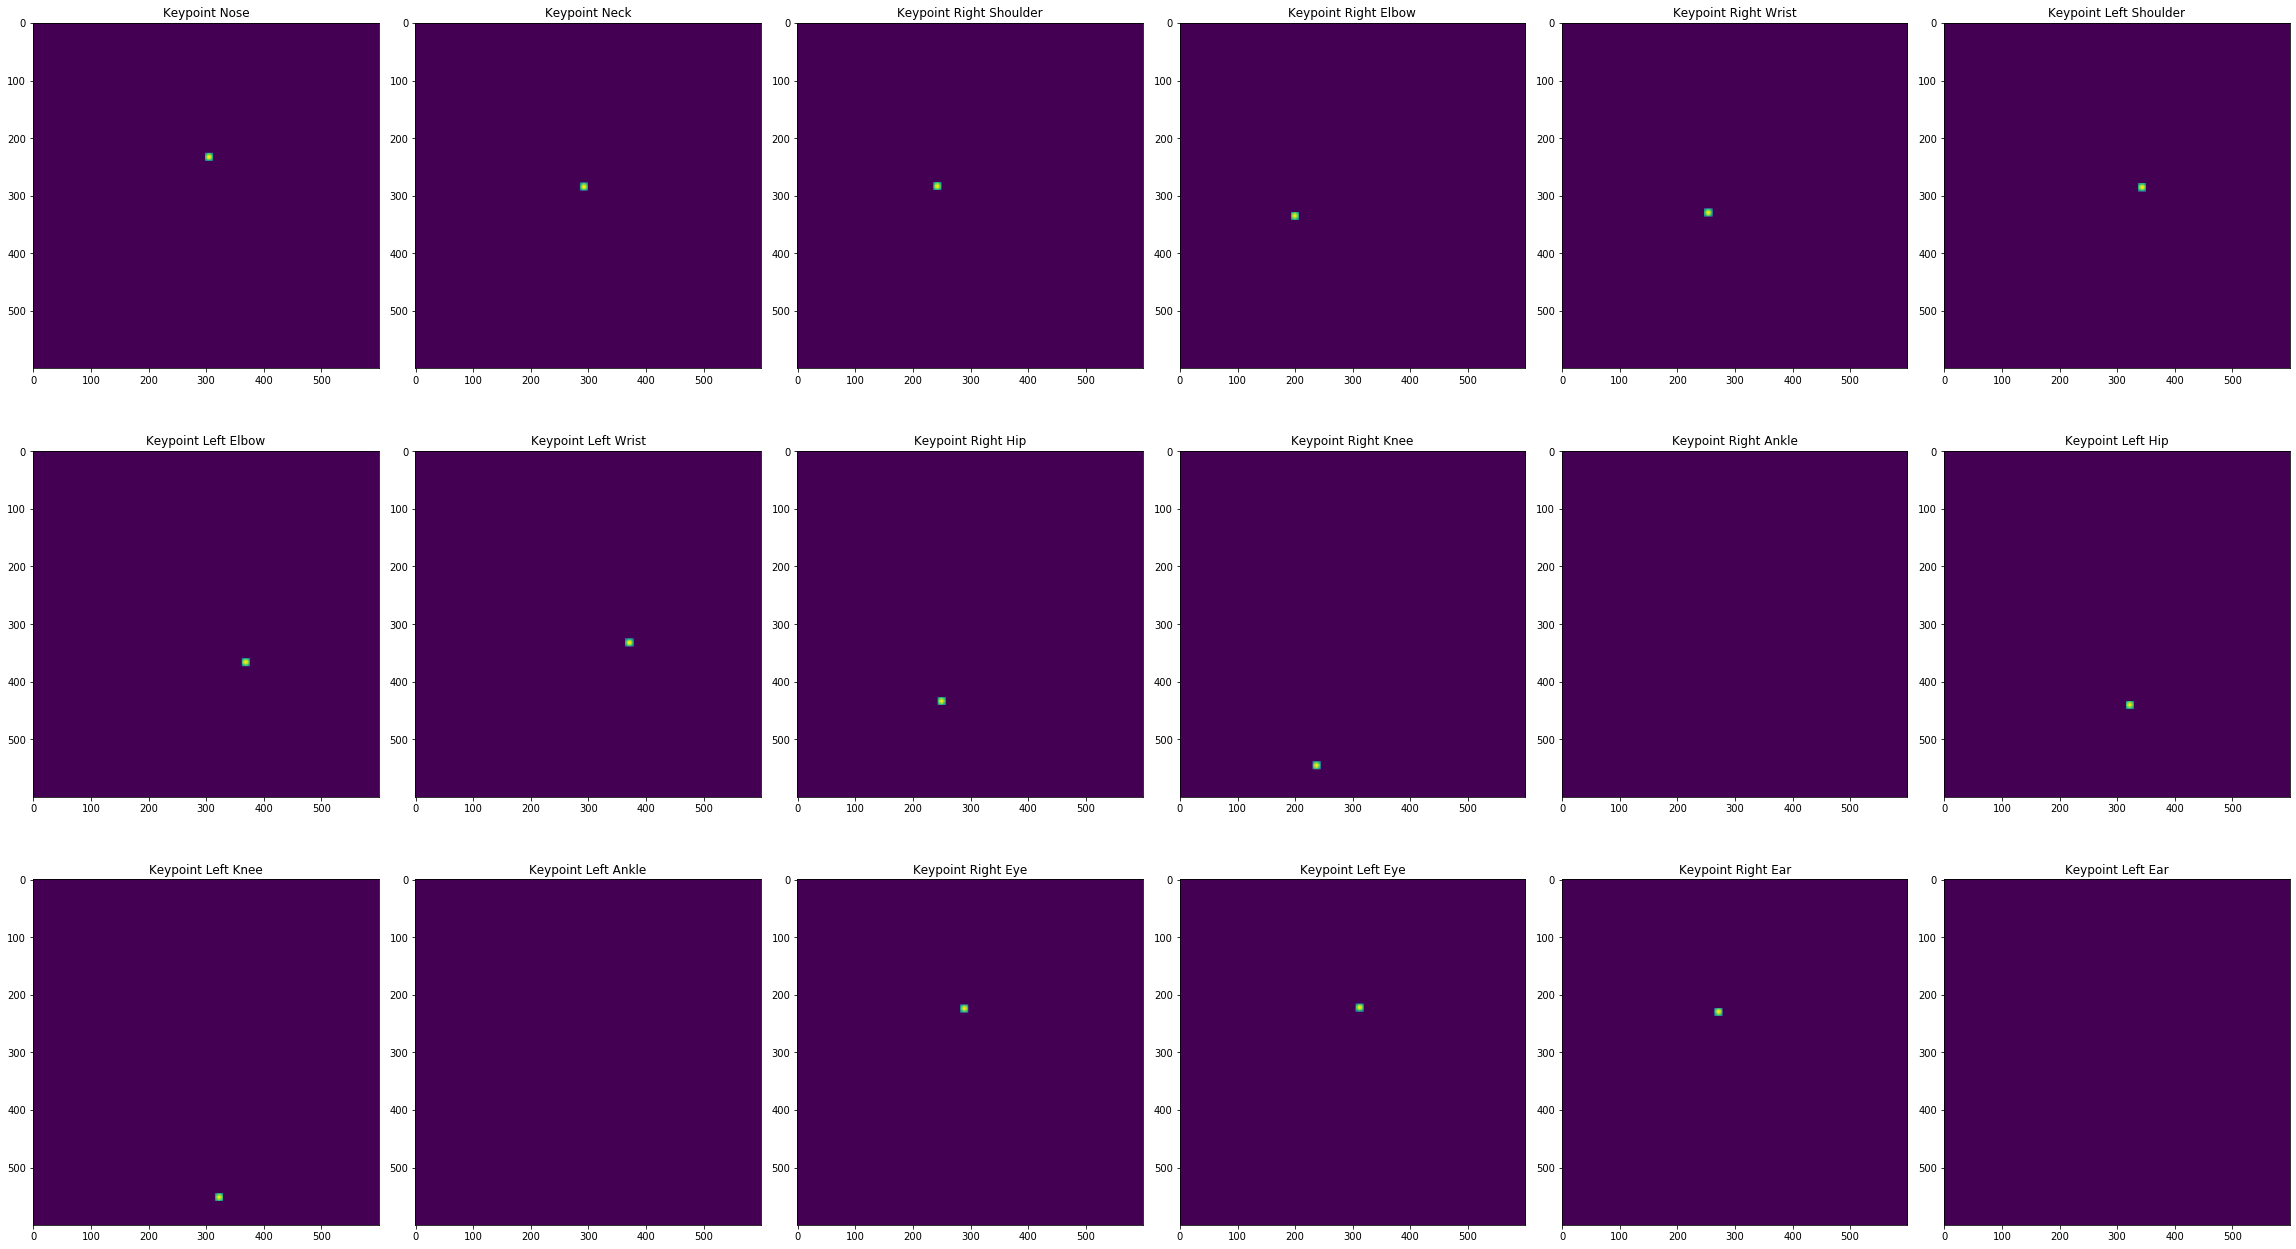

In [17]:
n_heatmaps = len(all_label_heats) - 1
plt.figure(figsize=(32, 18))

for i in range(n_heatmaps):
    plt.subplot(3,6,i+1)
    plt.imshow(all_label_heats[i,:])
    plt.title(f"Keypoint {IDX_TO_NAME[i]}")
    
plt.tight_layout()
plt.show()

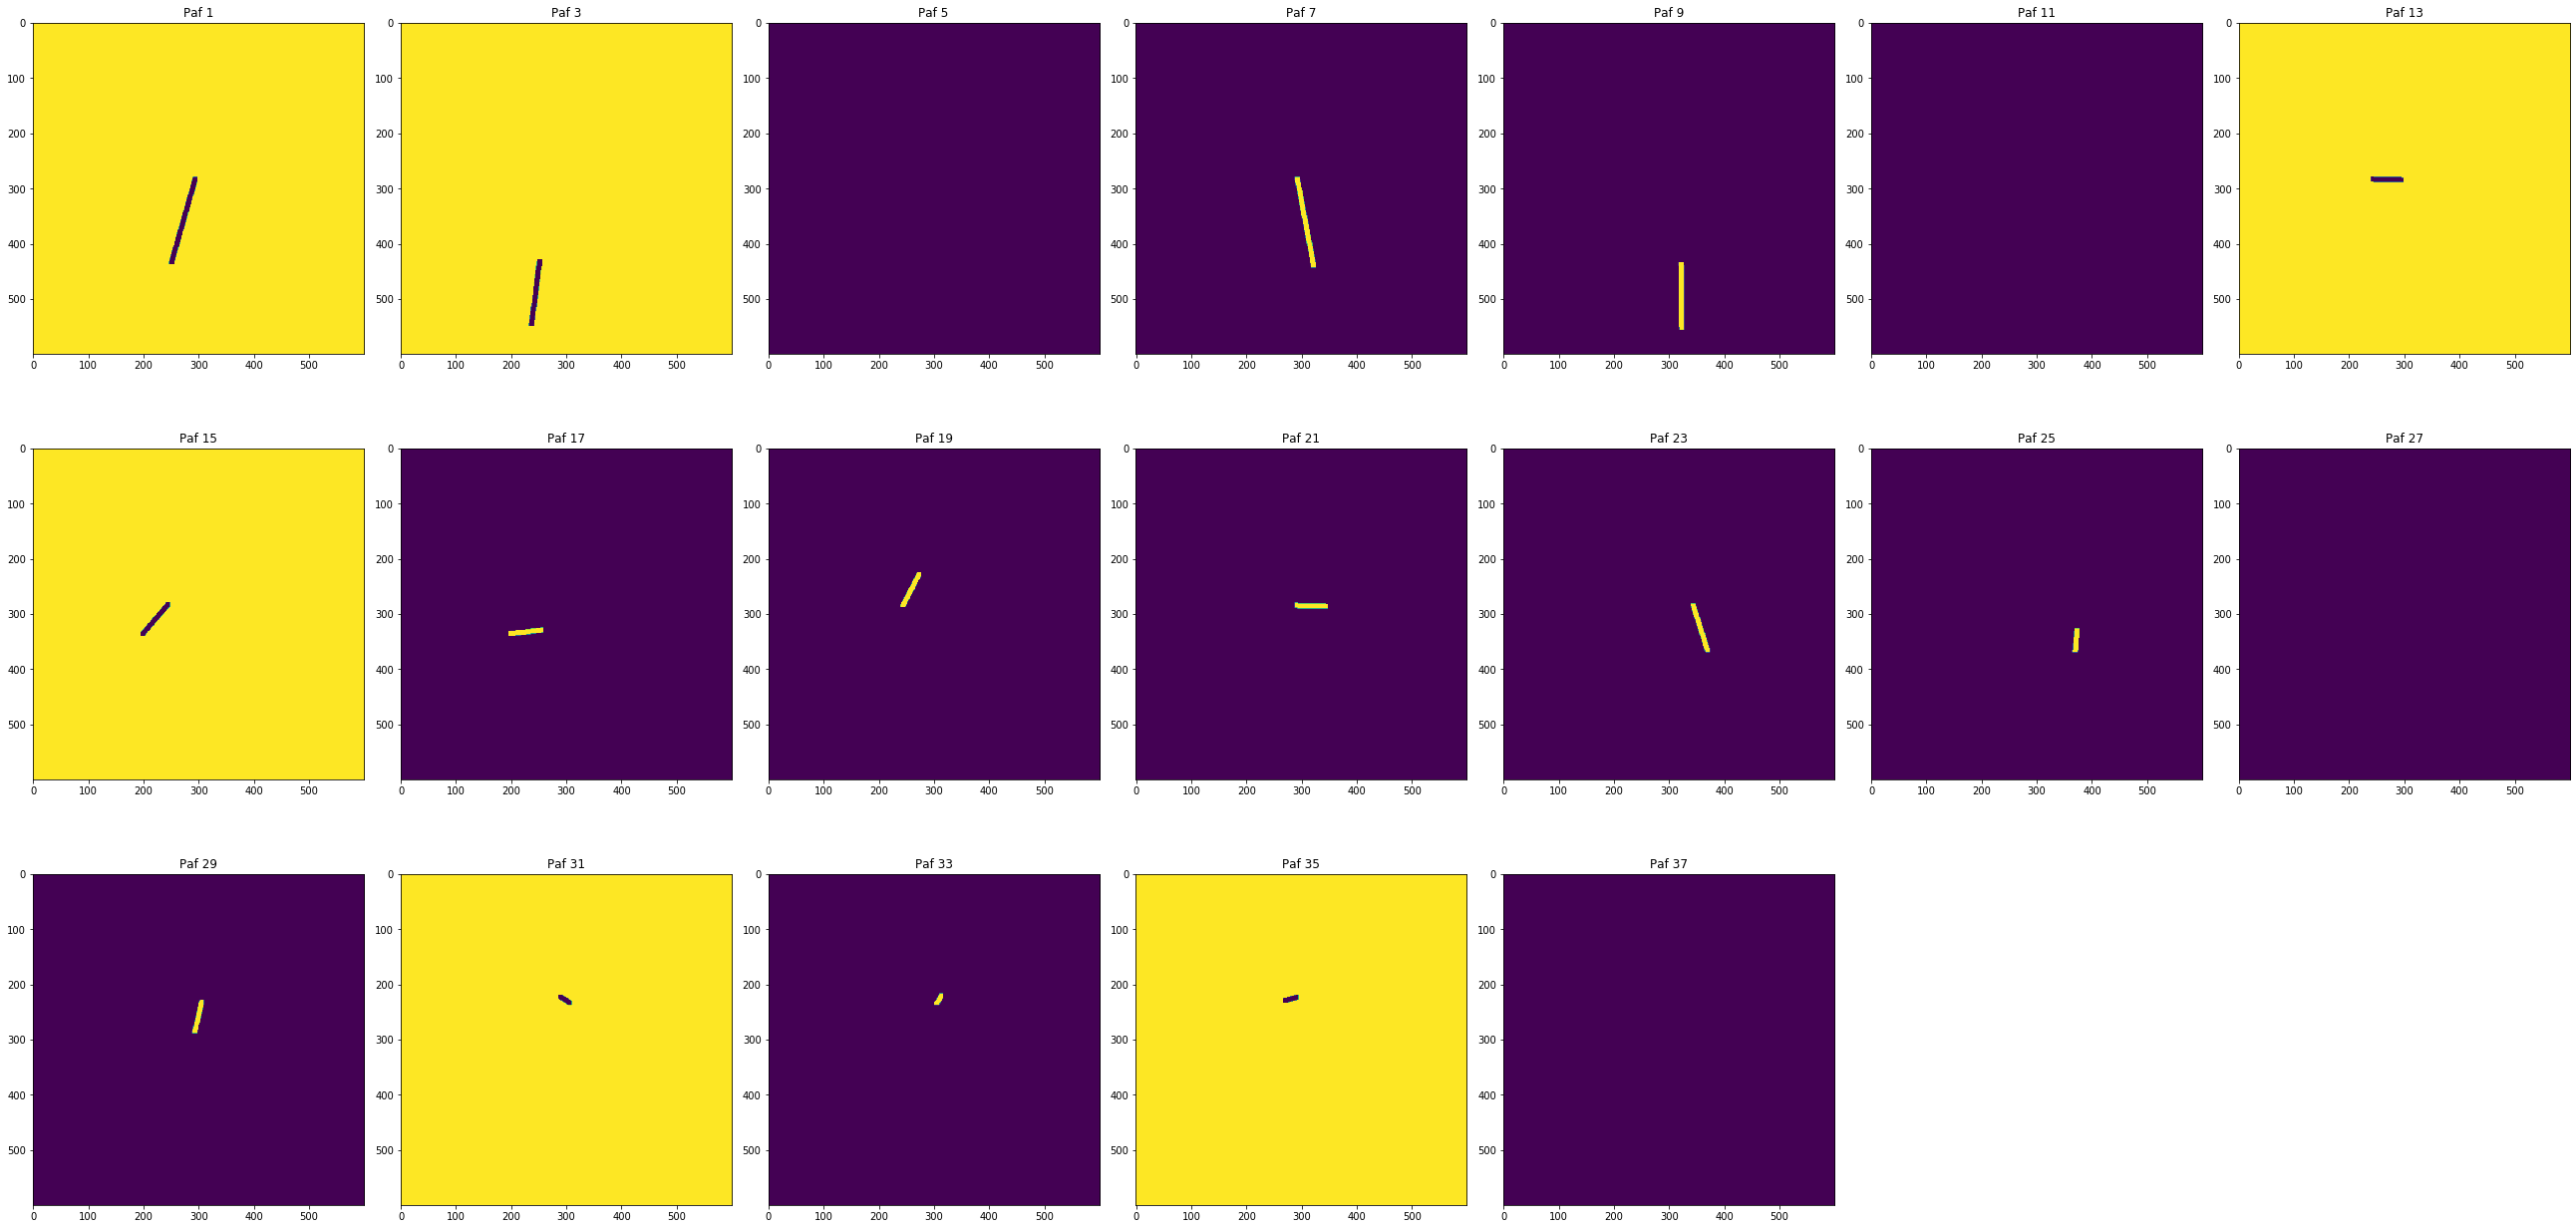

In [18]:
n_pafs = len(all_label_pafs)
plt.figure(figsize=(36, 18))

for i in range(n_pafs//2):
    cur_paf = all_label_pafs[i*2,:]    
    plt.subplot(3,7,i+1)
    plt.imshow(cur_paf)
    plt.title(f"Paf {2*i+1}")
    
plt.tight_layout()
plt.show()

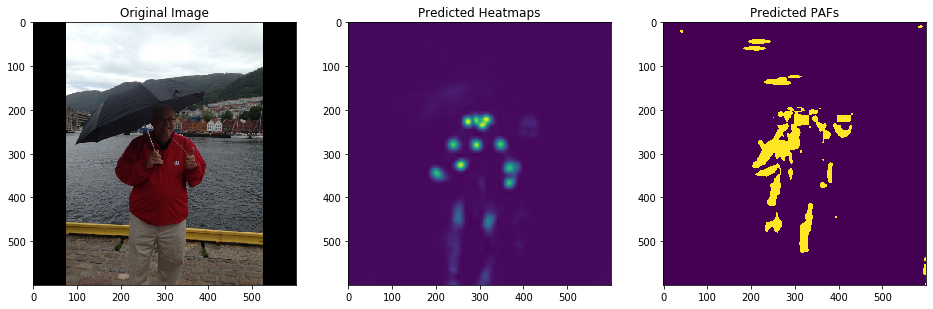

In [19]:
plt.figure(figsize=(16, 5))

plt.subplot(1,3,1)
ax = plt.gca()
visualizations.visualize_image(cur_img, ax=ax, title="Original Image")

plt.subplot(1,3,2)
ax = plt.gca()
visualizations.visualize_heatmap(cur_heats, ax=ax, title="Predicted Heatmaps")

plt.subplot(1,3,3)
ax = plt.gca()
visualizations.visualize_paf(cur_pafs, ax=ax, title="Predicted PAFs")

plt.show()

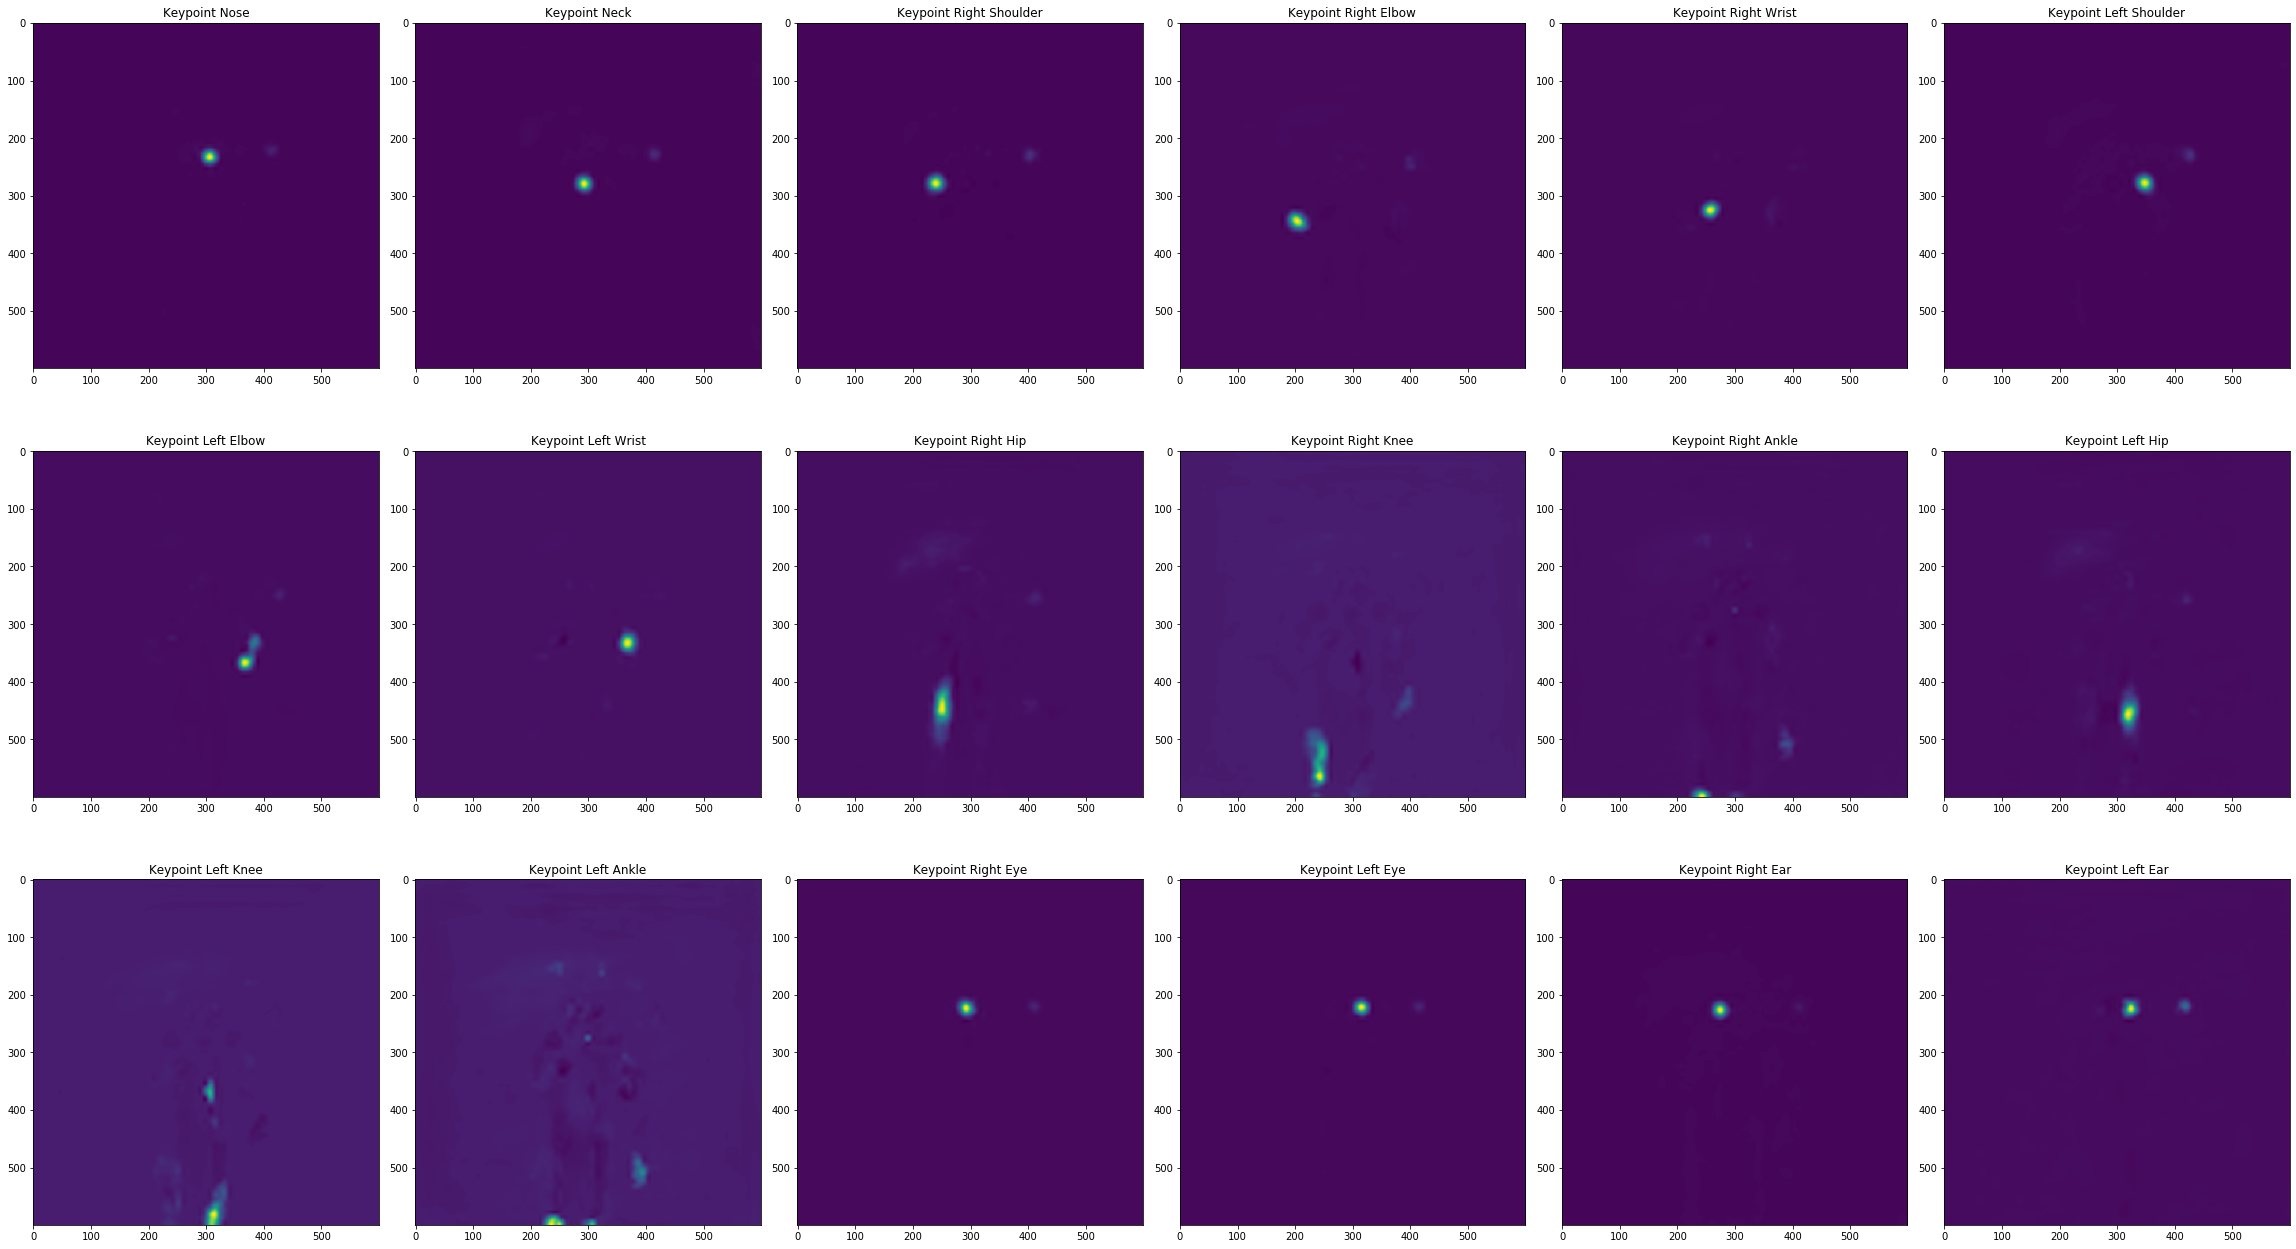

In [20]:
n_heatmaps = len(all_pred_heats) - 1
plt.figure(figsize=(32, 18))

for i in range(n_heatmaps):
    plt.subplot(3,6,i+1)
    plt.imshow(all_pred_heats[i,:])
    plt.title(f"Keypoint {IDX_TO_NAME[i]}")
    
plt.tight_layout()
plt.show()

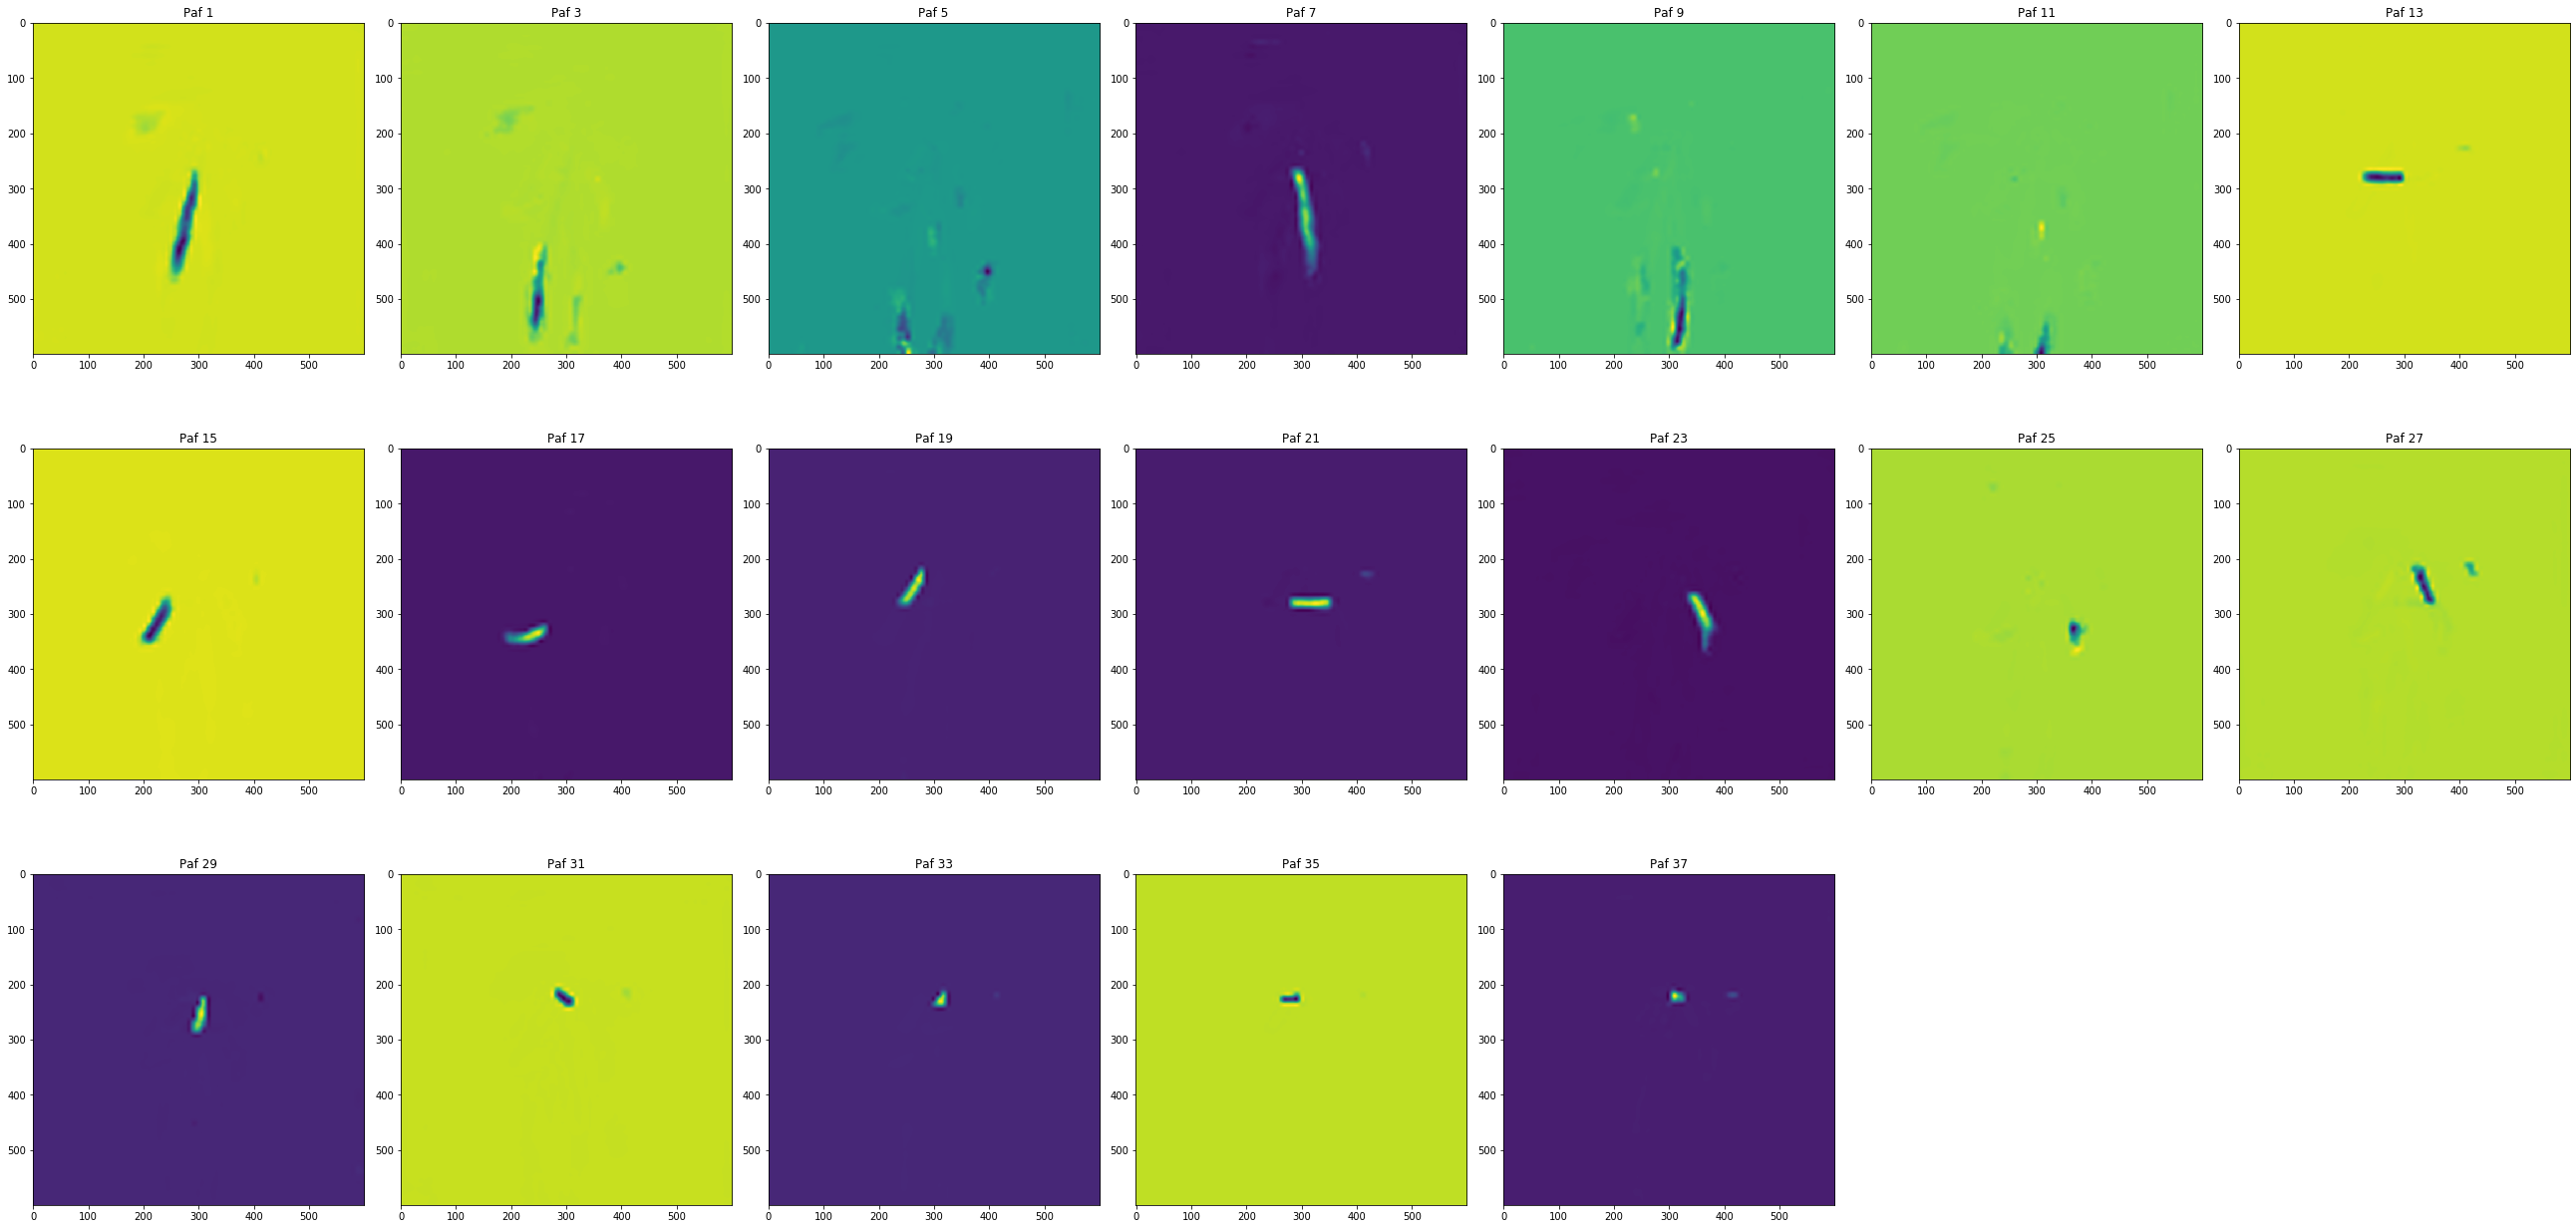

In [21]:
n_pafs = len(all_pred_pafs)
plt.figure(figsize=(36, 18))

for i in range(n_pafs//2):
#     cur_paf = all_pred_pafs[i,:]
    cur_paf = all_pred_pafs[i*2,:]
    plt.subplot(3,7,i+1)
    plt.imshow(cur_paf)
    plt.title(f"Paf {2*i+1}")
    
plt.tight_layout()
plt.show()

## Comparing Detections and Ground Truth

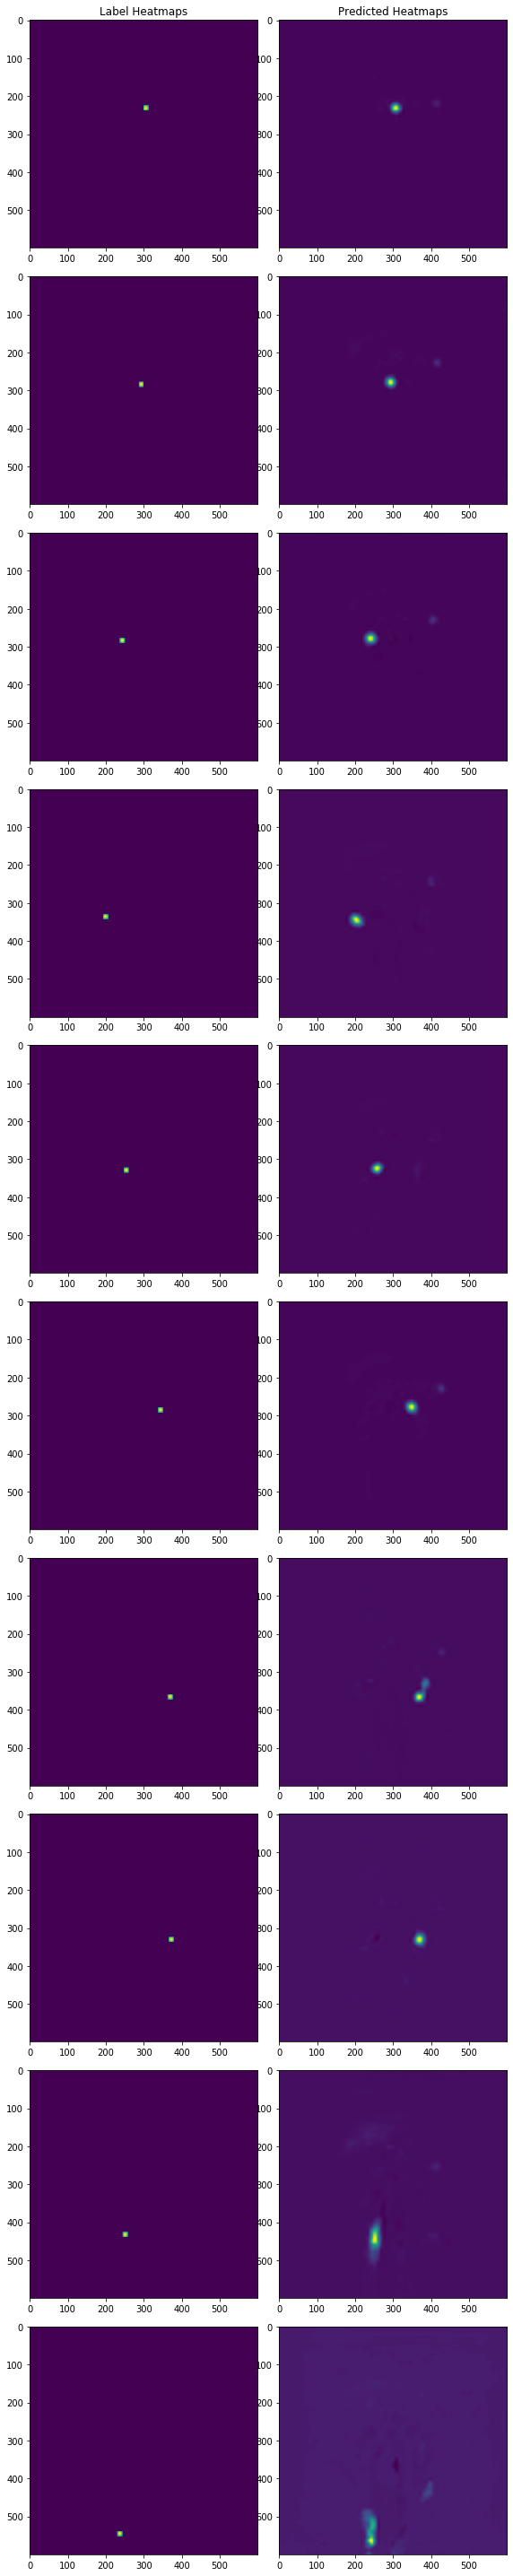

In [22]:
plt.figure(figsize=(8,40))
for i in range(10):
    label_heat = all_label_heats[i,:]
    plt.subplot(10,2,2*i+1)
    plt.imshow(label_heat)
    if(i==0):
        plt.title("Label Heatmaps")
        
    pred_heat = all_pred_heats[i,:]
    plt.subplot(10,2,2*i+2)
    plt.imshow(pred_heat)
    if(i==0):
        plt.title("Predicted Heatmaps")

plt.tight_layout()
plt.show()

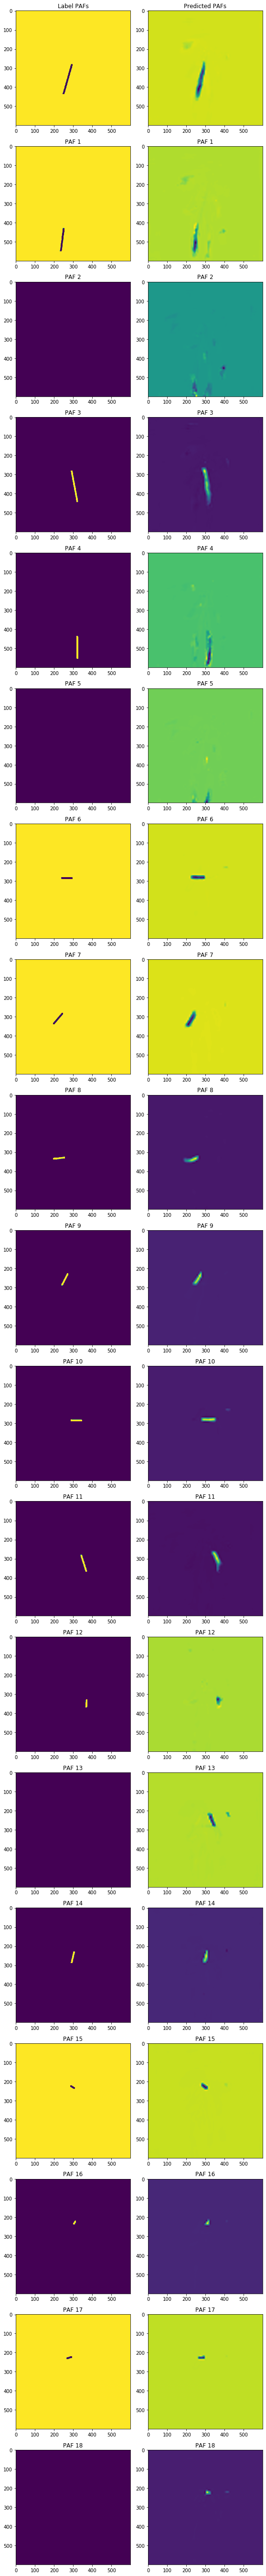

In [23]:
plt.figure(figsize=(8,75))
for i in range(19):
    label_paf = all_label_pafs[i*2,:]
    plt.subplot(19,2,2*i+1)
    plt.imshow(label_paf)
    if(i==0):
        plt.title("Label PAFs")
    else:
        plt.title(f"PAF {i}")
        
    pred_paf = all_pred_pafs[i*2,:]
    plt.subplot(19,2,2*i+2)
    plt.imshow(pred_paf)
    if(i==0):
        plt.title("Predicted PAFs")
    else:
        plt.title(f"PAF {i}")

plt.tight_layout()
plt.show()

## Testing Pose Parsing


In [25]:
coords_1, keypoints_1 = pose_parsing.extract_joins_heatmap(all_label_heats, min_distance=1, thr=0.5)
coords_2, keypoints_2 = pose_parsing.extract_joins_heatmap(all_pred_heats, min_distance=1, thr=0.5)

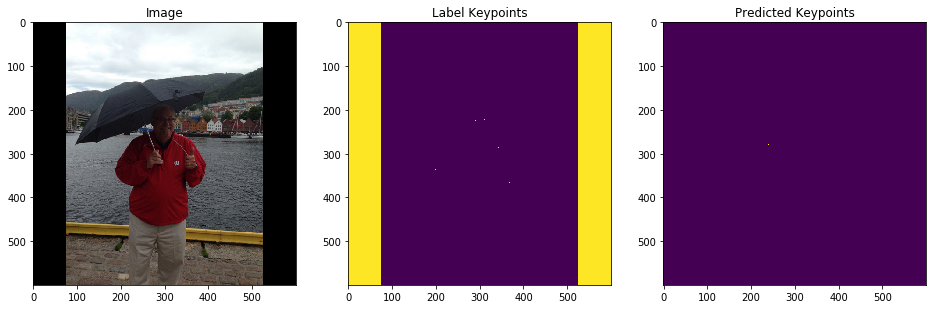

In [26]:
plt.figure(figsize=(16,5))

aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)

plt.subplot(1,3,1)
plt.imshow(aux_img)
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(coords_1)
plt.title("Label Keypoints")

plt.subplot(1,3,3)
plt.imshow(coords_2)
plt.title("Predicted Keypoints")

plt.show()

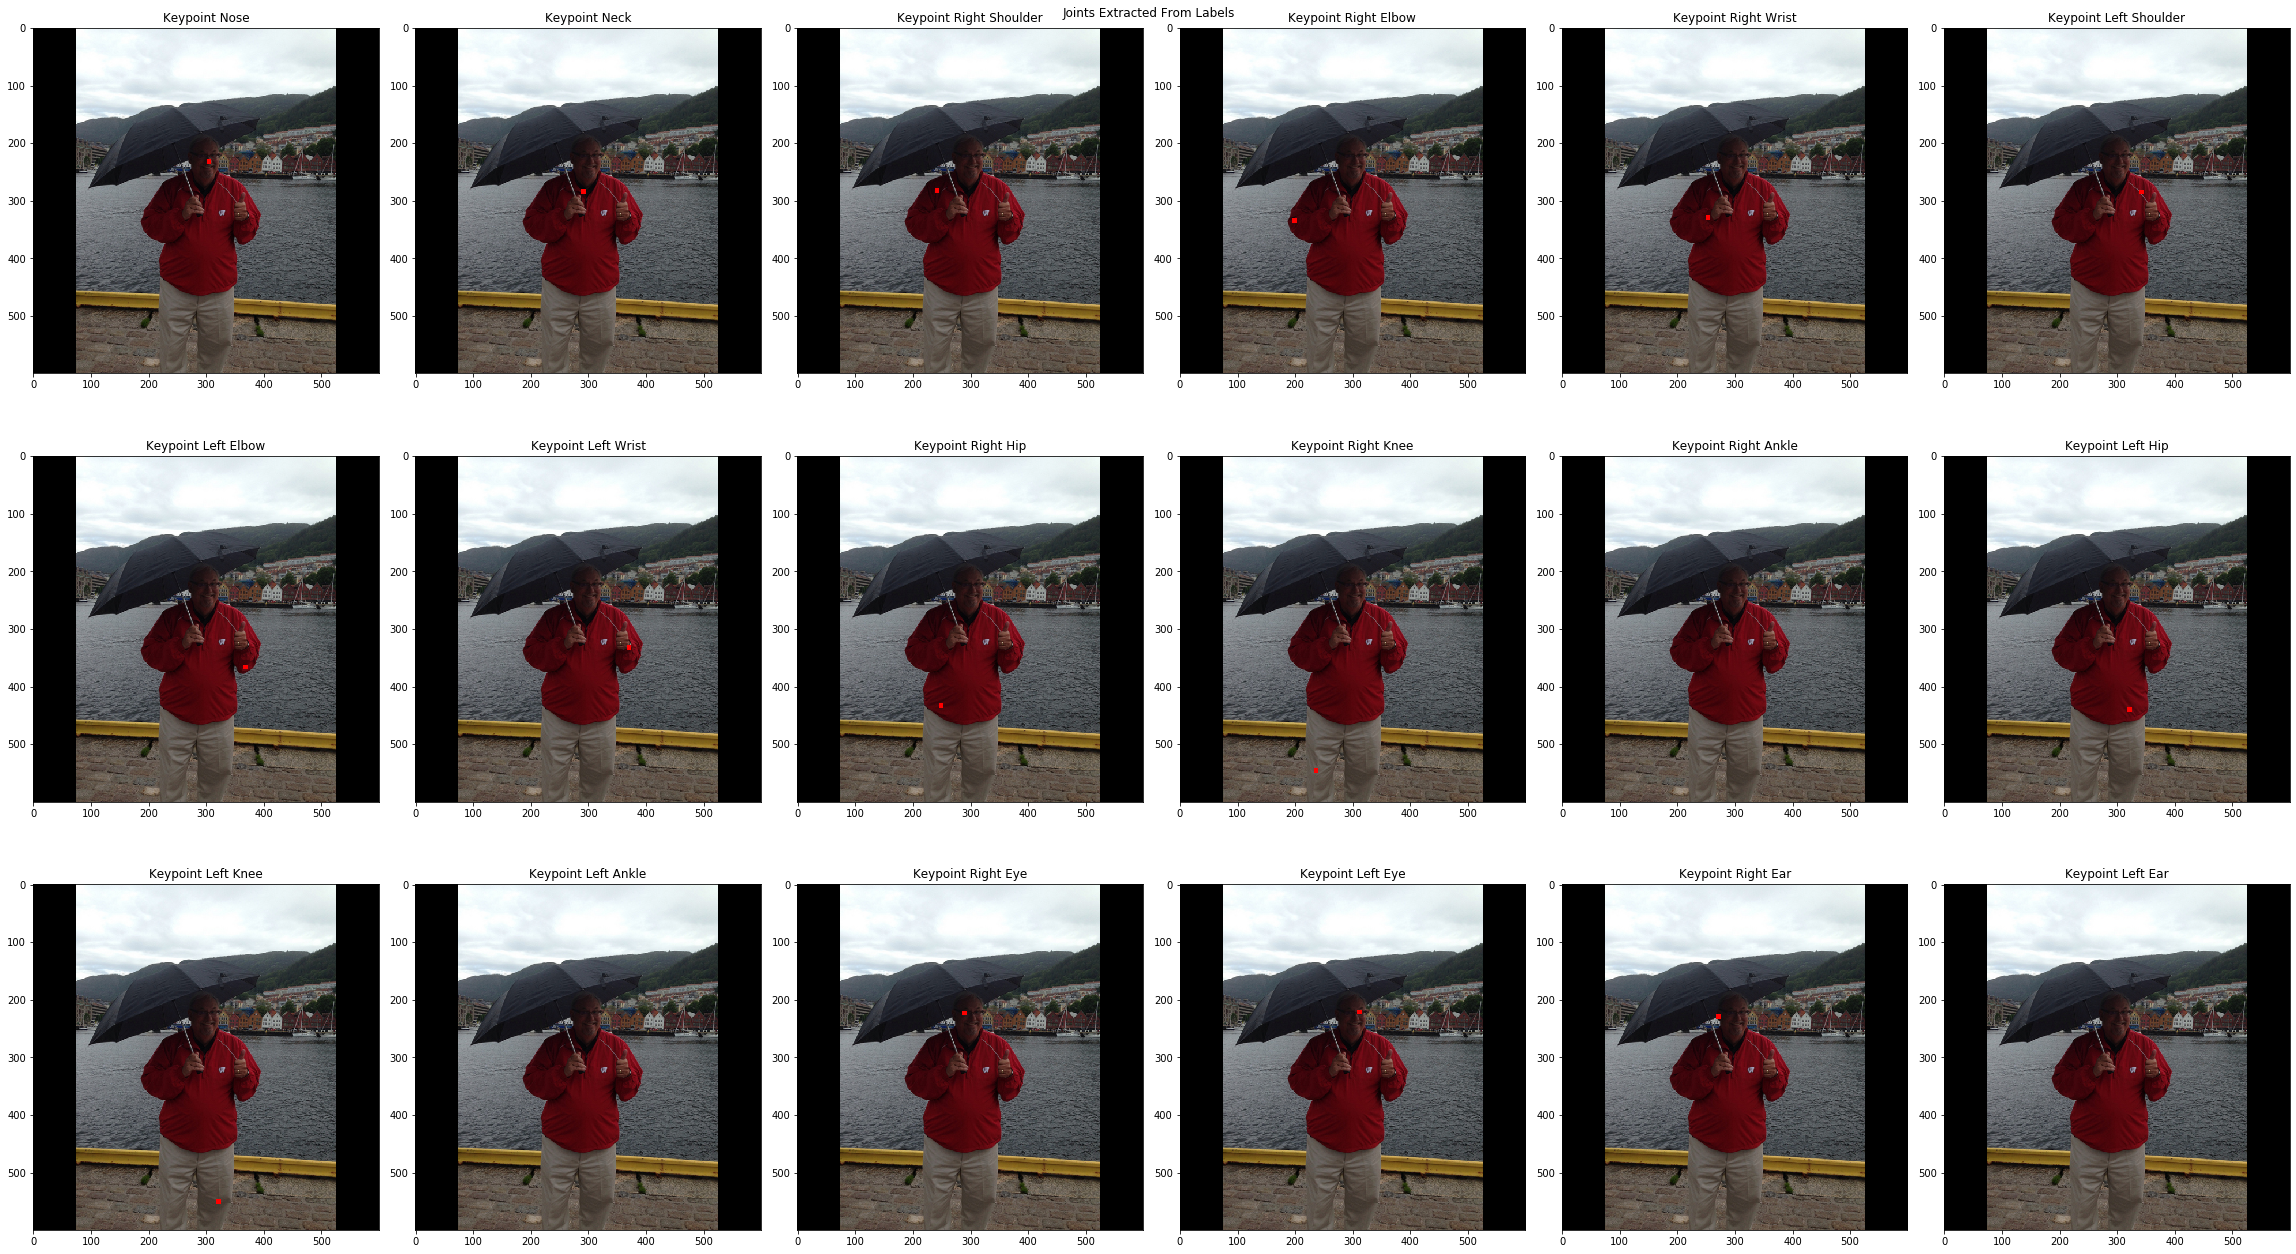

In [27]:
plt.figure(figsize=(32, 18))
zoom = 4

aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)

for i, keypoint in enumerate(keypoints_1):
    
    aux = np.copy(aux_img)
    if(len(keypoint) > 0):
        for k in keypoint:
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,0] = 255
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,1] = 0
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,2] = 0
    
    plt.subplot(3,6,i+1)
    plt.imshow(aux)
    plt.title(f"Keypoint {IDX_TO_NAME[i]}")
    
plt.suptitle("Joints Extracted From Labels")
plt.tight_layout()
plt.show()

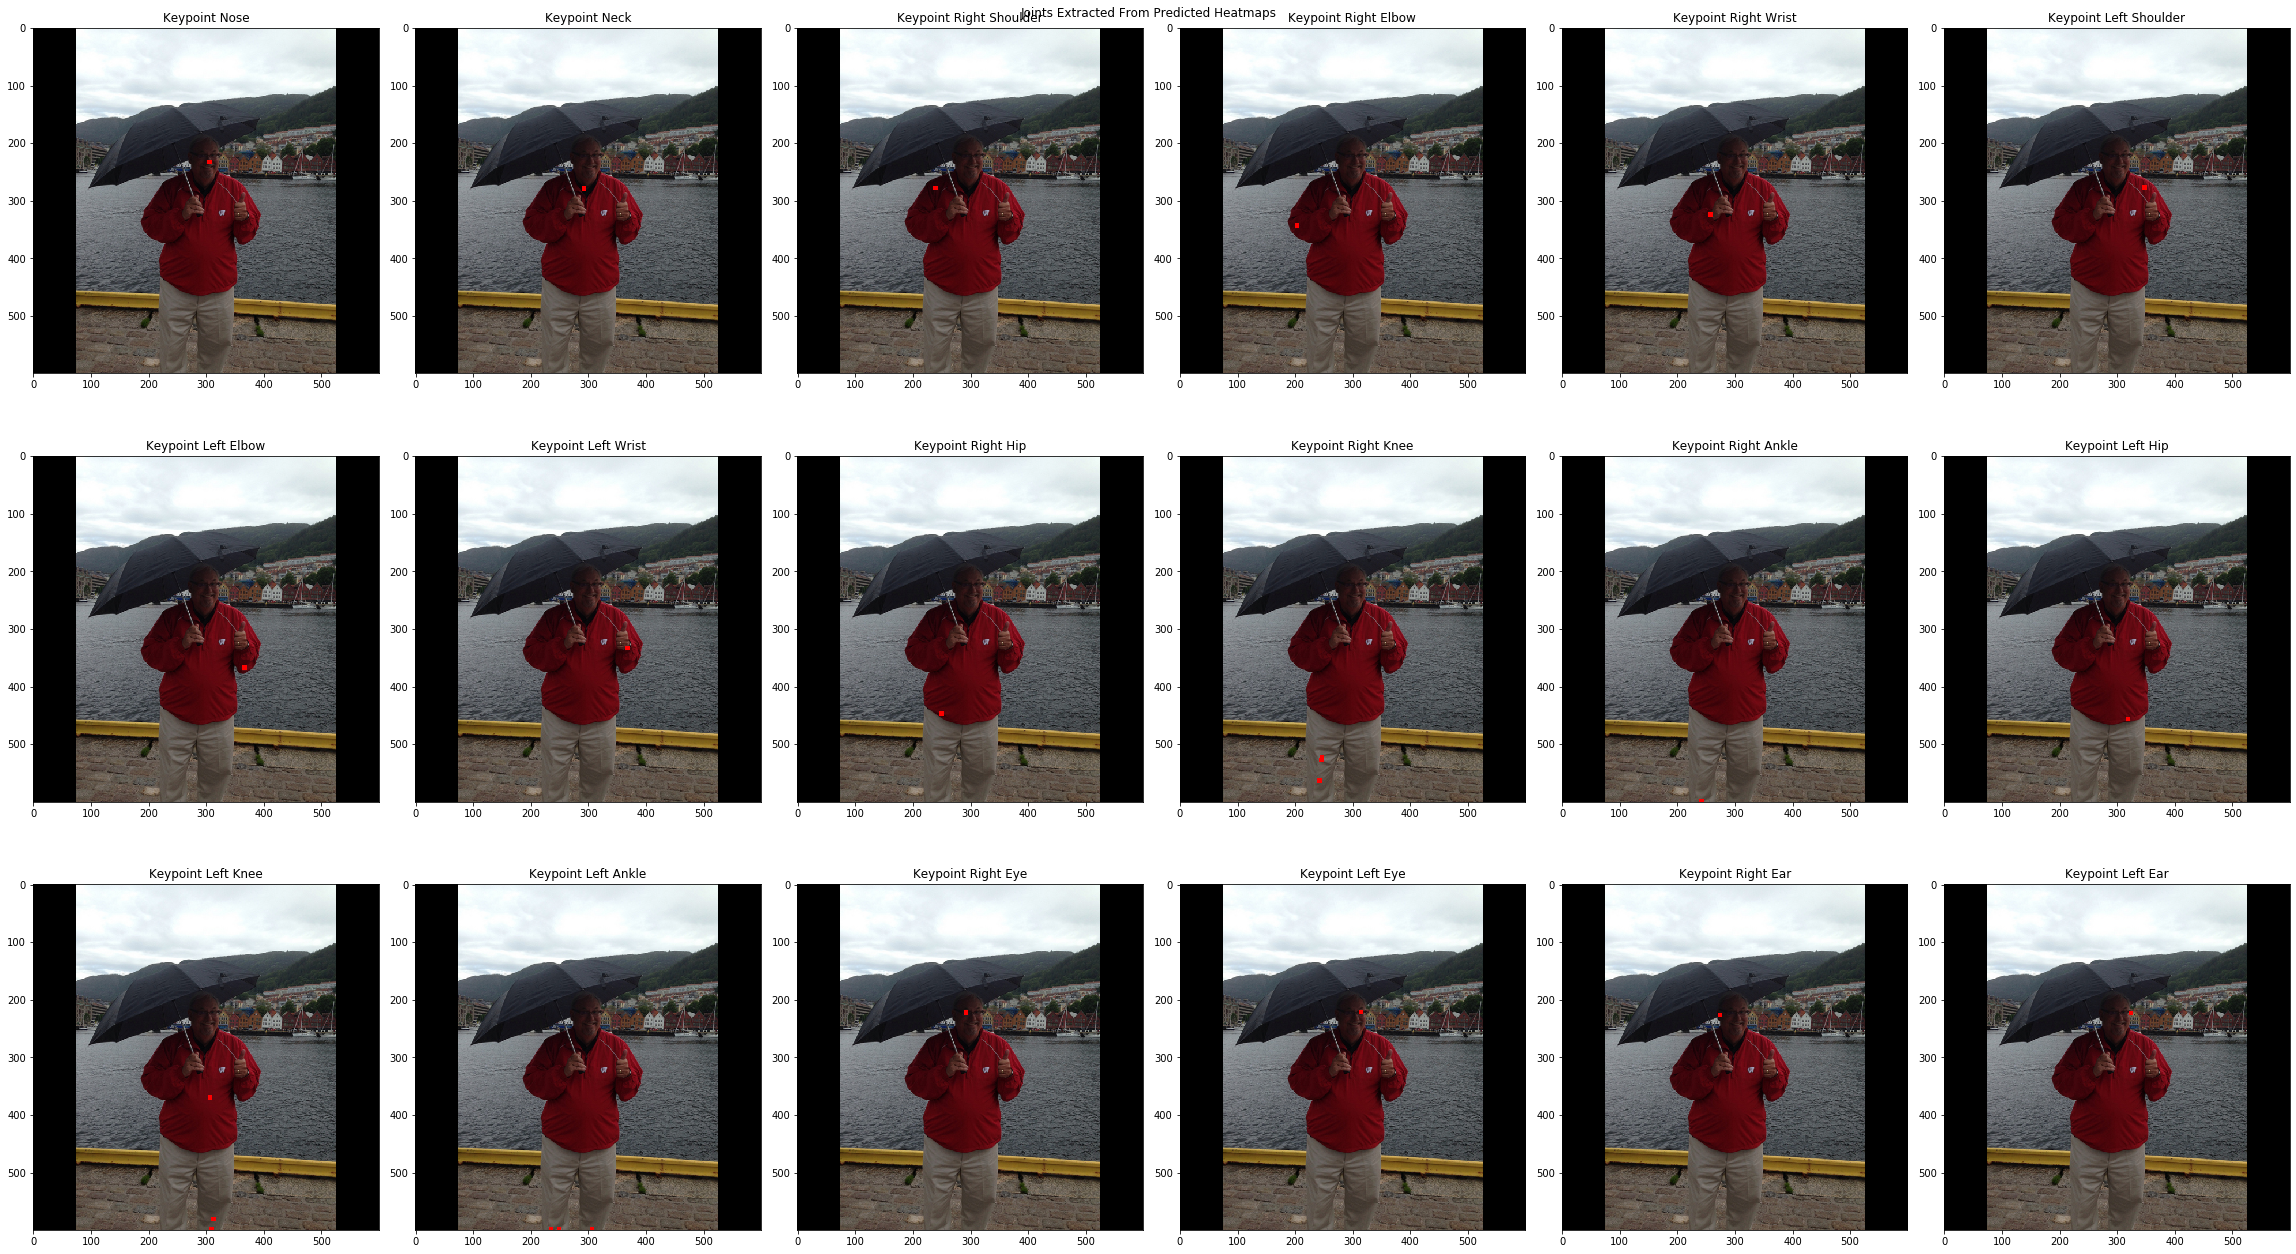

In [28]:
plt.figure(figsize=(32, 18))
zoom = 4

aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)

for i, keypoint in enumerate(keypoints_2):
    
    aux = np.copy(aux_img)
    if(len(keypoint) > 0):
        for k in keypoint:
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,0] = 255
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,1] = 0
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,2] = 0
    
    plt.subplot(3,6,i+1)
    plt.imshow(aux)
    plt.title(f"Keypoint {IDX_TO_NAME[i]}")
    
plt.suptitle("Joints Extracted From Predicted Heatmaps")
plt.tight_layout()
plt.show()

0.0
-0.1250608116388321
0.9921491146087646
0.0


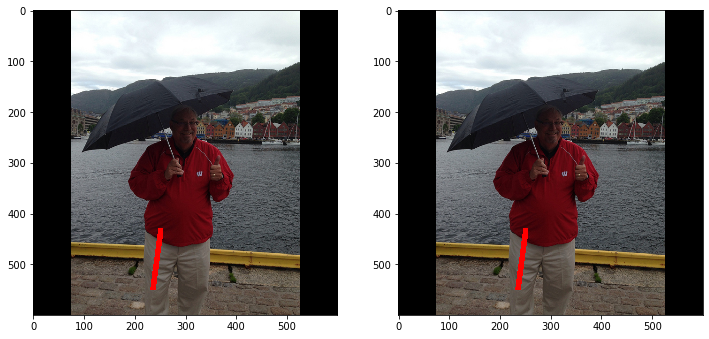

In [29]:
a = all_label_pafs[2,:]
b = all_label_pafs[3,:]

print(np.max(a))
print(np.min(a))
print(np.max(b))
print(np.min(b))

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
idx = np.argwhere(a!=0)
aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)
aux_img[idx[:,0],idx[:,1],0] = 255
aux_img[idx[:,0],idx[:,1],1] = 0
aux_img[idx[:,0],idx[:,1],2] = 0
plt.imshow(aux_img)

plt.subplot(1,2,2)
idx = np.argwhere(b!=0)
aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)
aux_img[idx[:,0],idx[:,1],0] = 255
aux_img[idx[:,0],idx[:,1],1] = 0
aux_img[idx[:,0],idx[:,1],2] = 0
plt.imshow(aux_img)

plt.show()

In [30]:
pose_parsing.BODY_PARTS_PAF_IDS = CONSTANTS.BODY_PARTS_PAF_IDS_OPEN_POSE
pose_parsing.SKELETON = CONSTANTS.SKELETON_OPEN_POSE

In [31]:
len(keypoints_1)

18

In [32]:
pose_entries, all_keypoints = pose_parsing.group_keypoints(keypoints_1, all_label_pafs)

In [33]:
pose_entries_det, all_keypoints_det = pose_parsing.group_keypoints(keypoints_2, all_pred_pafs, thr_ratio=0.8)

In [34]:
print(len(pose_entries))
print(len(pose_entries_det))

2
1


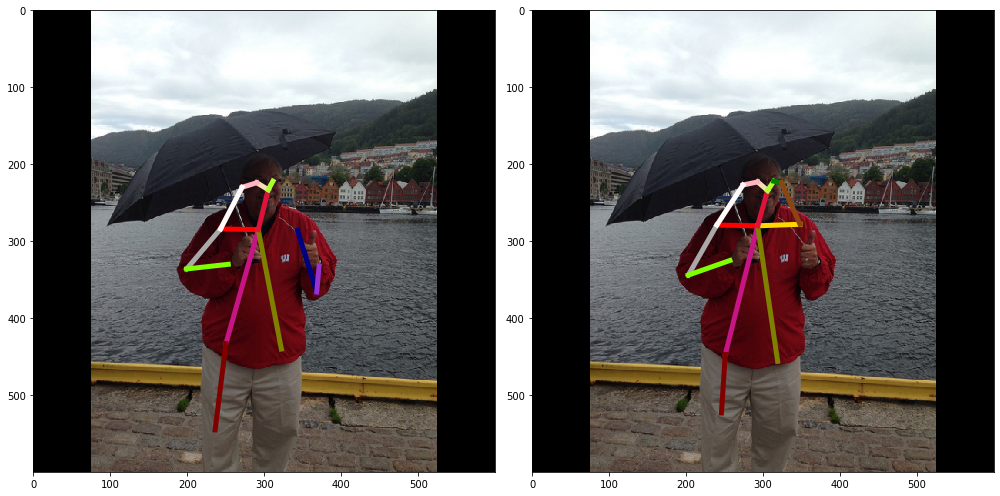

In [35]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
ax = plt.gca()
title = "Pose from Labels"
visualizations.draw_pose(cur_img, pose_entries, all_keypoints, ax=ax, title=title)

plt.subplot(1,2,2)
ax = plt.gca()
title = "Predicted Poses"
visualizations.draw_pose(cur_img, pose_entries_det, all_keypoints_det, ax=ax, title=title)


plt.tight_layout()
plt.show()

## Evaluation

In [37]:
print(all_pred_heats.shape)
print(all_pred_pafs.shape)
print(metadata)
image_size = 600

(19, 600, 600)
(38, 600, 600)
{'image_name': ['000000213033.jpg'], 'image_shape': tensor([[640, 480]])}


In [38]:
# computing predictions, loading previous results and appending new ones
utils.reset_predictions_file(test_exp)
cur_predictions = metrics.compute_predictions(all_pred_heats, all_pred_pafs, metadata, cur_size=image_size, thr=0.5, thr_ratio=0.8)
# cur_predictions = metrics.compute_predictions(np.array(all_label_heats[0,:]), np.array(all_label_pafs[0,:]), metadata, cur_size=image_size)
utils.update_predictions_file(cur_predictions, test_exp)

In [39]:
data_path = CONFIG["paths"]["data_path"]
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")
preds_file = os.path.join(test_exp, CONFIG["paths"]["submission"])

In [40]:
stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_file)

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | m

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 